# Weather Forecasting

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import os
import logging
import numpy as np
import pandas as pd
from zipfile import ZipFile
from datetime import datetime
import typing as tp

from IPython.display import display
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import TransformerMixin, RegressorMixin
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

import statsmodels.api as sm
import pmdarima as pm
from tbats import TBATS
from xgboost import XGBRegressor

rcParams["figure.figsize"] = 15, 7

sns.set(palette = "Set2", font_scale = 1.3)

In [2]:
compare_table = None

def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    
    global compare_table
    
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast),
        'Median_error': median_absolute_error(y_true,y_forecast),
        'R^2' : r2(y_true,y_forecast)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

In [3]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
!wget {uri}

zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

--2023-04-30 17:17:23--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.220.128, 64.233.162.128, 64.233.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.220.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.4’

jena_climate_2009_2 100%[===================>]  12,94M  3,70MB/s    in 3,5s    

2023-04-30 17:17:27 (3,70 MB/s) - ‘jena_climate_2009_2016.csv.zip.4’ saved [13568290/13568290]



In [4]:
zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

Немного преобразуем данные, рассмотрев значение каждой величины за сутки:

In [5]:
weather_df = pd.read_csv(csv_path)
weather_df["Date"] = pd.to_datetime(weather_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

weather_df_daily = weather_df.set_index("Date").resample('D').max().reset_index()
del weather_df_daily["Date Time"]
weather_df_daily = weather_df_daily.set_index('Date')
weather_df_daily.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date,,,,,,,,,,,,,,
2016-12-28,1015.35,6.29,278.53,3.11,91.9,9.55,7.64,2.19,4.70,7.54,1275.20,4.08,7.45,348.3
2016-12-29,1015.21,4.55,276.65,2.43,98.1,8.46,7.28,1.79,4.47,7.17,1297.30,2.04,2.80,344.8
2016-12-30,1012.55,3.67,276.11,2.97,98.2,7.95,7.56,1.70,4.67,7.49,1312.47,2.20,3.77,282.7
2016-12-31,1008.67,5.21,278.12,-3.04,91.8,8.86,4.88,4.03,3.03,4.86,1314.79,1.49,2.75,333.3
2017-01-01,999.82,-4.82,268.36,-8.42,75.7,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


Разделим данные на обучающие и тестовые. В качестве тестового отрезка времени возьмем данные за последний год. Обратим внимание, что за 2016-10-26 и 2016-10-27 данных нет.

In [6]:
insert_df = pd.concat([weather_df_daily.loc['2016-10-25', :], weather_df_daily.loc['2016-10-28', :]], axis = 1, ignore_index = False).transpose()
new_index = ['2016-10-26', '2016-10-27']
insert_df = insert_df.rename(index = dict(zip(insert_df.index, new_index)))

In [7]:
weather_df_daily = pd.concat(
                      [weather_df_daily.loc[weather_df_daily.index < '2016-10-26'],
                      insert_df,
                      weather_df_daily.loc[weather_df_daily.index > '2016-10-27']],
                      axis = 0,
)

In [8]:
weather_df_daily.index = pd.to_datetime(weather_df_daily.index)

In [9]:
weather_df_daily['Target'] = weather_df_daily['T (degC)'].shift(-1)
weather_df_daily.drop('2017-01-01', axis = 0, inplace = True)

In [224]:
test_size = 366
df_train = weather_df_daily.iloc[ : -test_size]
df_test = weather_df_daily.iloc[-test_size : ]

Визуализируем график температуры с годами:

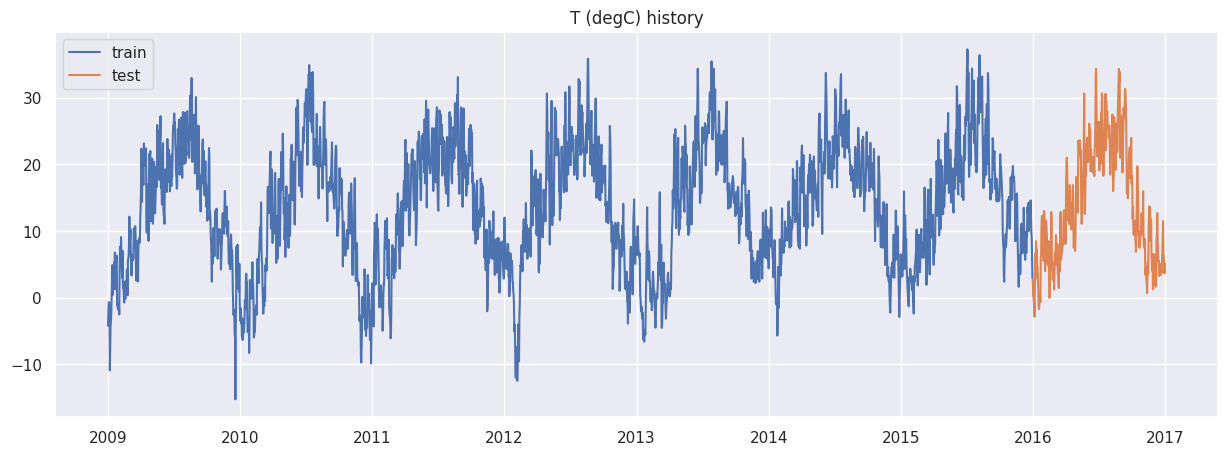

In [225]:
plt.figure(figsize = (15, 5))
plt.title("T (degC) history")
plt.plot(df_train.index, df_train['T (degC)'], label = 'train')
plt.plot(df_test.index, df_test['T (degC)'], label = 'test')
plt.legend();

In [226]:
target_train = df_train[['Target']].copy()
target_test = df_test[['Target']].copy()

Проведем простую аналитику:

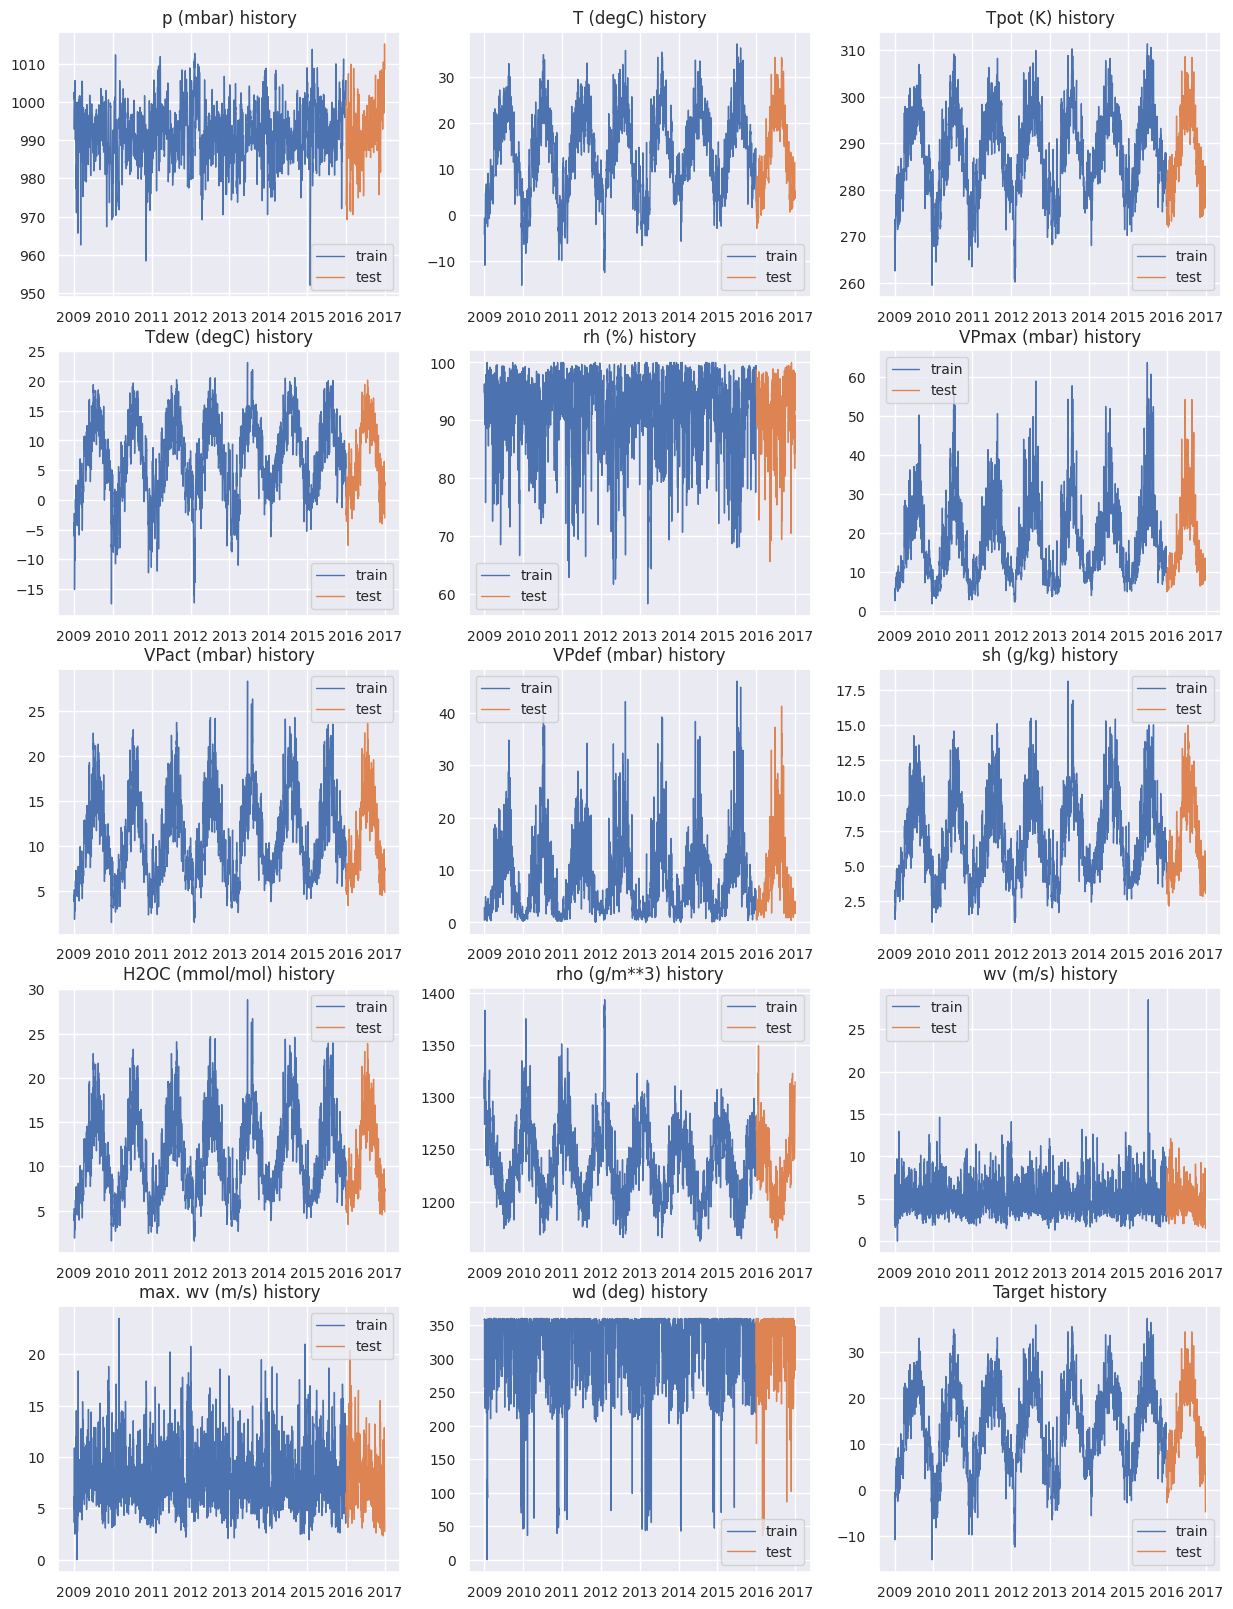

In [227]:
plt.figure(figsize = (15, 20))

for i, col in enumerate(df_train.columns):
    plt.subplot(5, 3, i + 1)
    plt.title(f"{col} history")
    plt.plot(df_train.index, df_train[col], label = 'train', lw = 1)
    plt.plot(df_test.index, df_test[col], label = 'test', lw = 1)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
    plt.legend(fontsize = 10)

plt.show()

Видим, что в данных есть немного явных выбросов, заклипаем их значениями год назад:

In [228]:
df_train.loc[df_train['wv (m/s)'] > 25]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Target
2015-07-13,990.94,19.96,294.01,14.98,94.6,23.36,17.06,9.23,10.79,17.23,1194.87,28.49,8.53,360.0,22.26


In [229]:
df_train.loc['2015-07-13', :]['wv (m/s)'] = df_train.loc['2014-07-13', :]['wv (m/s)'] 

In [230]:
df_train.loc[df_train['p (mbar)'] < 960]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Target
2010-11-09,958.31,7.78,284.57,3.65,97.9,10.58,7.94,3.14,5.18,8.30,1216.36,5.21,7.81,242.3,9.50
2015-01-30,951.94,2.42,279.66,0.59,93.8,7.28,6.38,2.53,4.20,6.73,1213.37,6.64,9.77,261.1,2.81


In [231]:
df_train.loc['2010-11-09', : ]['p (mbar)'] = df_train.loc['2009-11-09', :]['p (mbar)']
df_train.loc['2015-01-30', : ]['p (mbar)'] = df_train.loc['2014-01-30', :]['p (mbar)']

Теперь данные выглядят немного получше!

Посчитаем корреляционную матрицу:

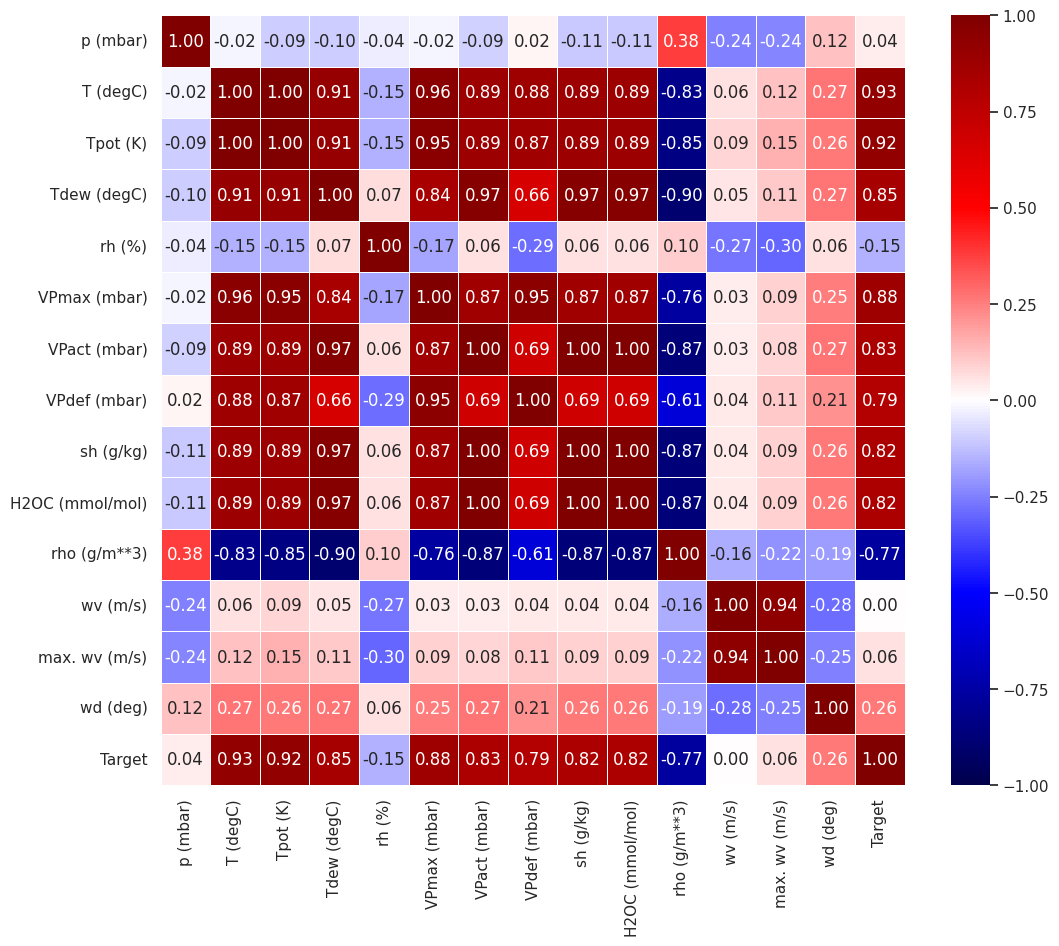

In [232]:
def high_correlated_cols(dataframe, plot = False, corr_th = 0.75):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k = 1).astype(np.bool_))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        sns.set(rc = {'figure.figsize': (12, 10)})
        sns.heatmap(corr, linewidth = 0.5, cmap = "seismic", vmin = -1, vmax = 1, fmt = '.2f', annot = True)
        plt.show(block=True)
        return drop_list
        
drop_list = high_correlated_cols(df_train, plot = True)

Видим, что много признаков не корреллируют с таргетом, также есть два, которые выражаются через температуру, удалим их:

In [19]:
drop_temp = ['Tpot (K)', 'Tdew (degC)']
drop_temp_and_low_cor = ['Tpot (K)', 'Tdew (degC)', 'wv (m/s)', 'max. wv (m/s)', 'p (mbar)', 'rh (%)']
drop_temp_and_high = ['Tpot (K)', 'Tdew (degC)', 'wv (m/s)', 'sh (g/kg)', 'H2OC (mmol/mol)']

In [20]:
df_train.drop(columns = drop_temp_and_low_cor, inplace = True)
df_test.drop(columns = drop_temp_and_low_cor, inplace = True)

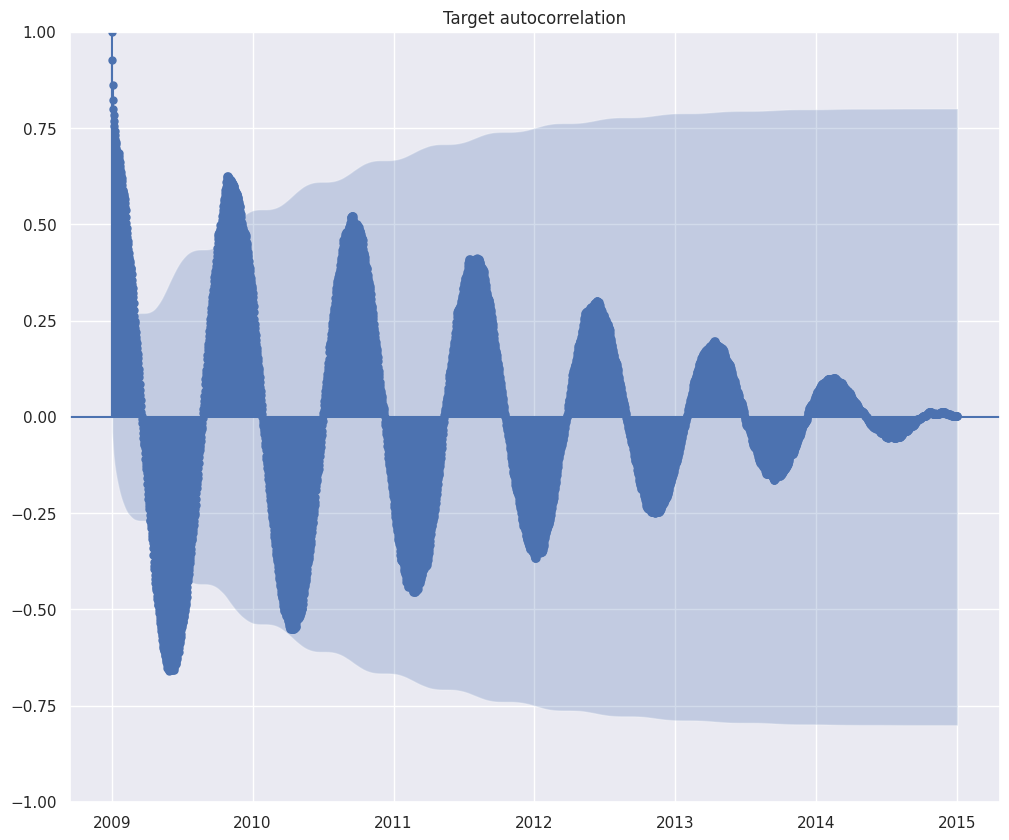

In [21]:
plot_acf(df_train['T (degC)'], lags = len(df_train) - 1);
x_ids = np.linspace(0, len(df_train) - 1, 7).astype(int)

plt.xticks(x_ids, df_train.index[x_ids].map(lambda x: str(x)[:4]))
plt.title('Target autocorrelation');

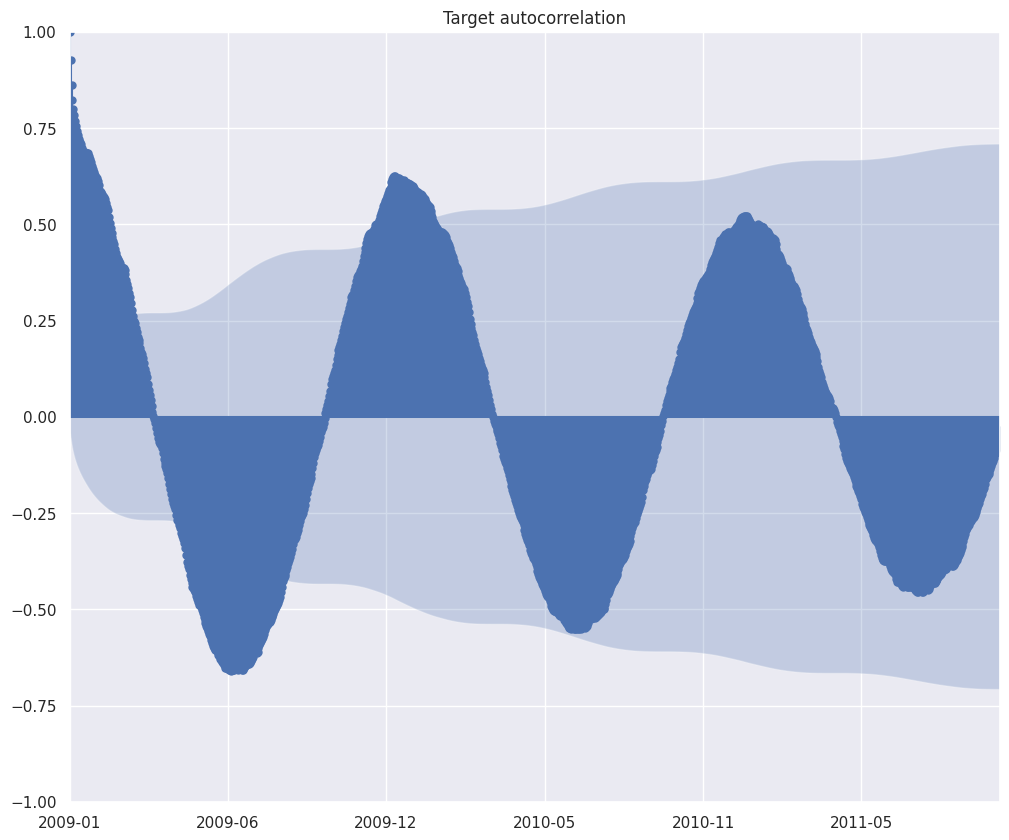

In [22]:
freq = 16

plot_acf(df_train['T (degC)'], lags = len(df_train) - 1);
x_ids = np.linspace(0, len(df_train) - 1, freq).astype(int)

plt.xticks(x_ids, df_train.index[x_ids].map(lambda x: str(x)[:7]))
plt.title('Target autocorrelation')
plt.xlim(0, 1000);

По временному ряду температуры выполним STL-разложение и визуализируем полученные компоненты:

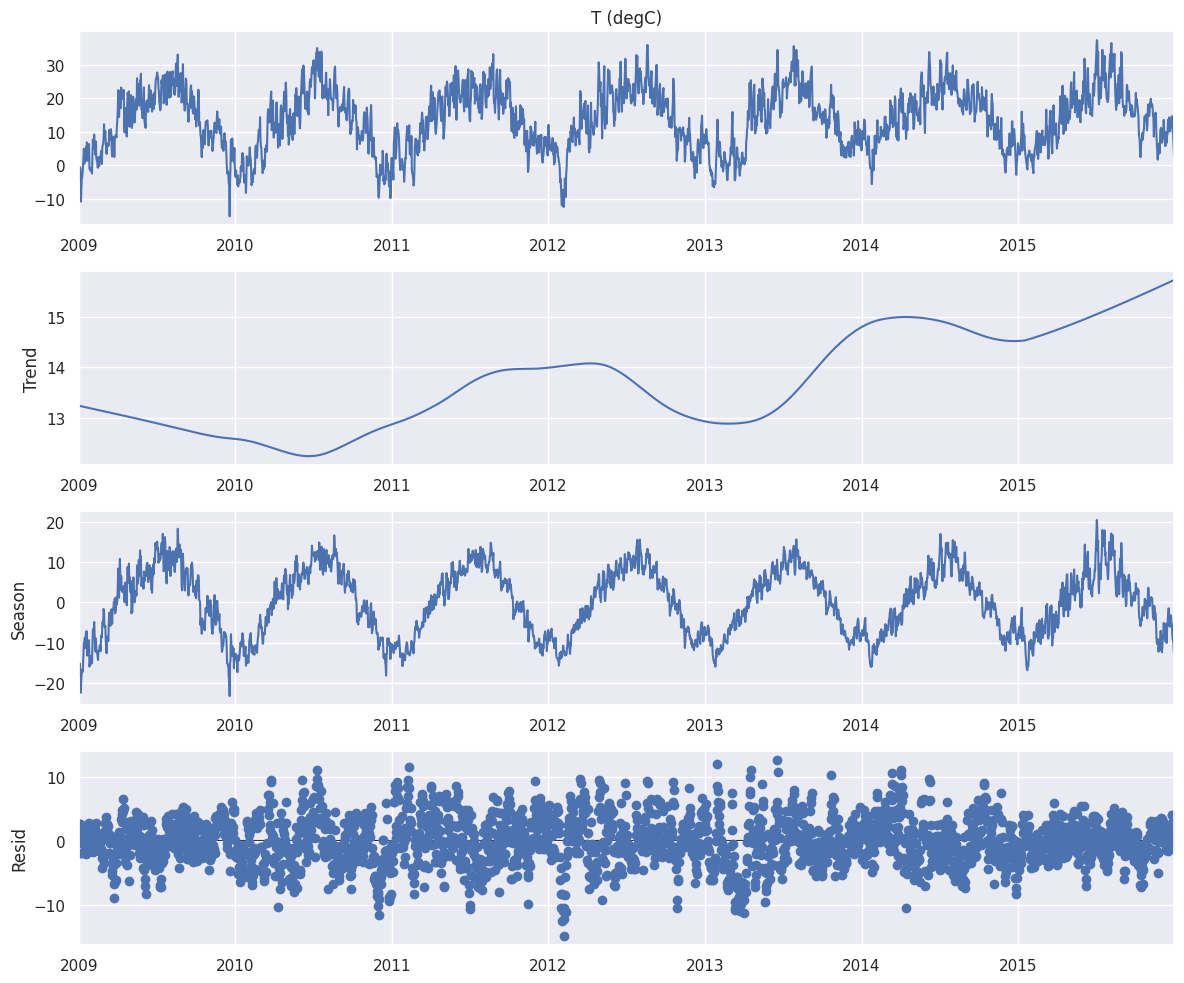

In [28]:
result = STL(df_train['T (degC)'], period = 365).fit()
result.plot();

**Выводы:**

1. Виден четкий тренд температуры: на увеличение. (он почти линейный)
2. Очевидная годовая сезонность
3. Остатки распределены почти нормально, не видно ни тренда, ни динамики - очень хорошо!  (а по сути видна небольшая динамика: сначала малый разброс, потом немного больше, а потом опять малый). Так что можно попробовать доразложить остатки.

Реализуем основные метрики:

In [27]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_error(y_true, y_pred):
    return np.median(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    residual = np.sum(np.square(y_true - y_pred))
    total = np.sum(np.square(y_true - np.mean(y_true)))
    r2 = 1 - residual / total
    return r2

def print_metrics(y_true, y_pred):
    print(f'MSE : ',  mean_squared_error(y_true, y_pred))
    print(f'MAE : ',  mean_absolute_error(y_true, y_pred))
    print(f'MAPE : ', mean_absolute_percentage_error(y_true, y_pred))
    print(f'MedAE : ', median_absolute_error(y_true, y_pred))
    print(f'R^2 : ', r2(y_true, y_pred))

## Теперь будем создавать фичи и обучать модели!

Начнем с базовой: линейной регрессии. Перед этим добавим немного скользящих фичей:

In [23]:
df_train.drop(columns = ['Target'], inplace = True)
df_test.drop(columns = ['Target'], inplace = True)

In [24]:
window_size = 7
for col in df_train.columns:
    df_train[f'{col}_wmean'] = df_train[col].rolling(window = window_size, min_periods = 1).mean()
    df_train[f'{col}_wmedian'] = df_train[col].rolling(window = window_size, min_periods = 1).median()
    df_train[f'{col}_wmin'] = df_train[col].rolling(window = window_size, min_periods = 1).min()
    df_train[f'{col}_wmax'] = df_train[col].rolling(window = window_size, min_periods = 1).max()

    df_test[f'{col}_wmean'] = df_test[col].rolling(window = window_size, min_periods = 1).mean()
    df_test[f'{col}_wmedian'] = df_test[col].rolling(window = window_size, min_periods = 1).median()
    df_test[f'{col}_wmin'] = df_test[col].rolling(window = window_size, min_periods = 1).min()
    df_test[f'{col}_wmax'] = df_test[col].rolling(window = window_size, min_periods = 1).max()

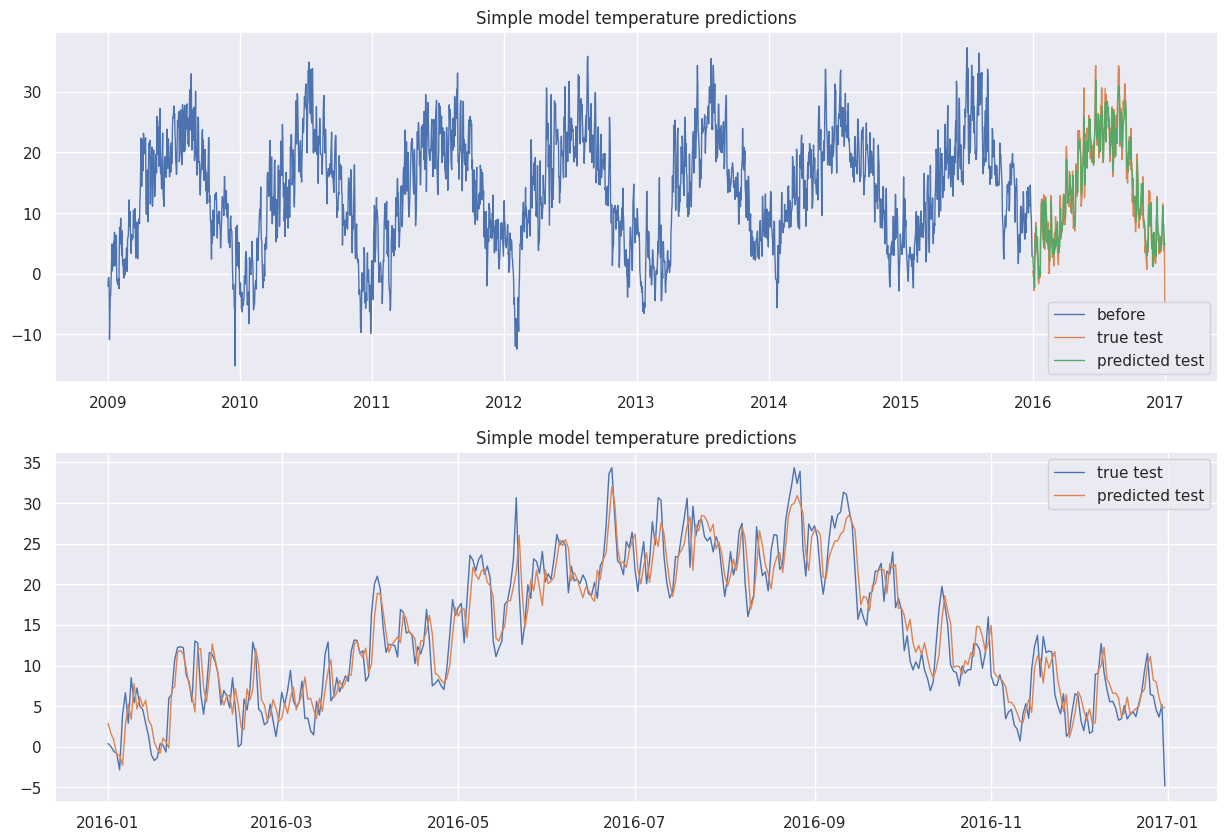

In [25]:
model = LinearRegression()
model.fit(df_train, target_train)
y_pred = model.predict(df_test)

plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.title('Simple model temperature predictions')
plt.plot(df_train.index, target_train, label = 'before', lw = 1)
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

plt.subplot(2, 1, 2)
plt.title('Simple model temperature predictions')
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

In [28]:
add_results_in_comparison_table(
                                method = 'baseline linreg',
                                y_true = target_test.values,
                                y_forecast = y_pred
)

,method,MSE,MAE,MAPE,Median_error,R^2
0,baseline linreg,8.429505,2.294389,187.648533,2.06533,0.891097


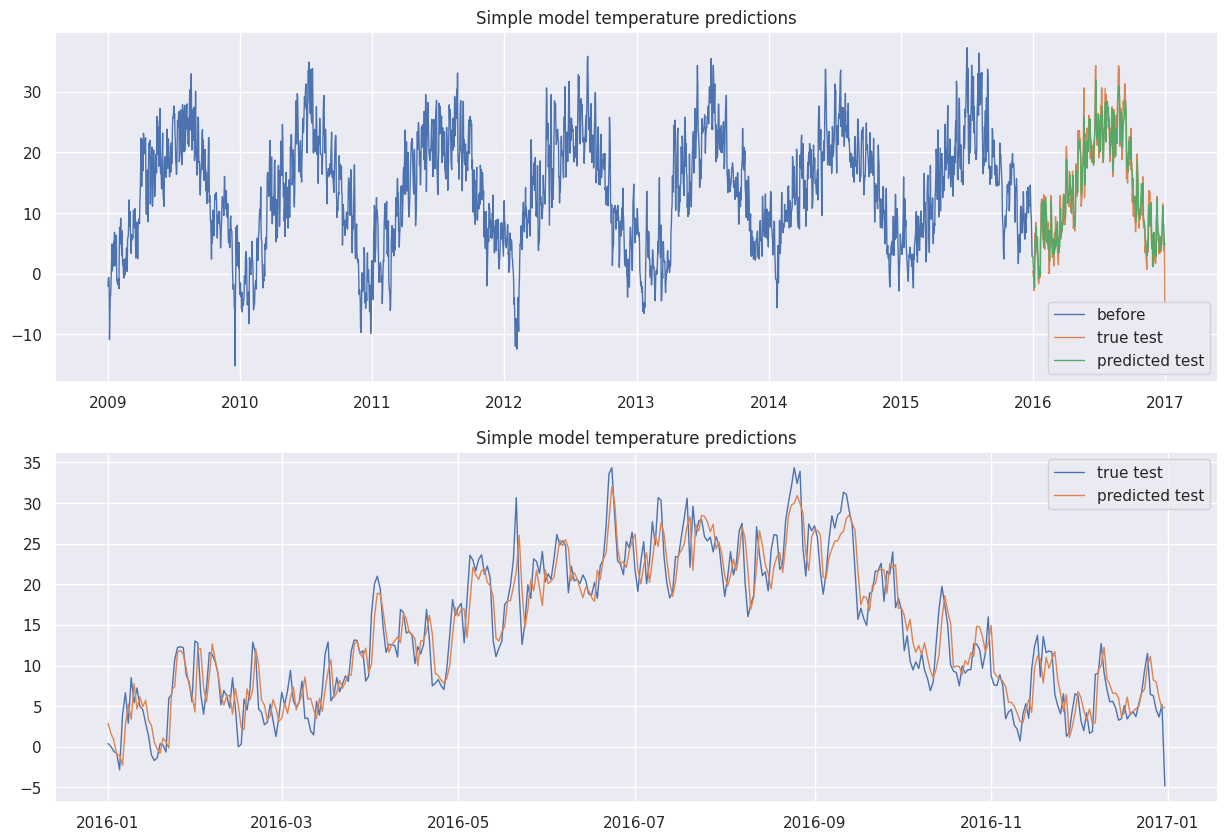

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train)
X_test = scaler.transform(df_test)

model = LinearRegression()
model.fit(X_train, target_train)
y_pred = model.predict(X_test)

plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.title('Simple model temperature predictions')
plt.plot(df_train.index, target_train, label = 'before', lw = 1)
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

plt.subplot(2, 1, 2)
plt.title('Simple model temperature predictions')
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

In [30]:
add_results_in_comparison_table(
                                method = 'baseline linreg norm',
                                y_true = target_test.values,
                                y_forecast = y_pred
)

,method,MSE,MAE,MAPE,Median_error,R^2
0,baseline linreg,8.429505,2.294389,187.648533,2.06533,0.891097
1,baseline linreg norm,8.429505,2.294389,187.648533,2.06533,0.891097


Видим, что нормализация не помогла улучшить результат (на самом деле различие есть и с нормализацией лучше, но в далеком знаке, будем иметь это ввиду). Проведем отбор признаков:

In [31]:
model = LinearRegression()
model.fit(df_train, target_train)

LinearRegression()

In [32]:
sorted_columns = []

for col, coef in sorted(zip(df_train.columns, model.coef_.squeeze()), key = lambda x: abs(x[1])):
    sorted_columns.append(col)
    print(f'{col} : {coef:5f}')

rho (g/m**3)_wmin : 0.002203
wd (deg)_wmedian : 0.002240
wd (deg)_wmin : 0.002433
wd (deg)_wmean : 0.003252
wd (deg) : -0.003416
rho (g/m**3)_wmedian : -0.010336
rho (g/m**3)_wmax : -0.010699
VPmax (mbar)_wmedian : -0.011311
rho (g/m**3)_wmean : 0.012140
wd (deg)_wmax : 0.012243
rho (g/m**3) : -0.016418
VPdef (mbar)_wmax : -0.030403
T (degC)_wmedian : -0.067619
H2OC (mmol/mol)_wmedian : -0.075500
VPdef (mbar)_wmedian : 0.078350
VPdef (mbar)_wmin : -0.125931
VPmax (mbar) : 0.155420
T (degC)_wmax : -0.172942
VPmax (mbar)_wmax : 0.184795
T (degC)_wmin : -0.235855
VPdef (mbar) : -0.261123
VPmax (mbar)_wmin : 0.357502
T (degC)_wmean : 0.508770
VPact (mbar)_wmin : 0.562255
VPact (mbar)_wmedian : -0.638776
VPdef (mbar)_wmean : 0.801113
VPact (mbar)_wmax : -0.860632
T (degC) : 0.861269
VPmax (mbar)_wmean : -1.169653
sh (g/kg)_wmedian : 1.406697
VPact (mbar)_wmean : -1.499794
sh (g/kg) : -6.450465
H2OC (mmol/mol)_wmin : -6.999328
H2OC (mmol/mol) : -7.941527
sh (g/kg)_wmin : 10.463713
VPact (mba

Будем выкидывать фичи с самыми маленькими коэффициентами последовательно и будем смотреть на R^2 и MAE:

In [36]:
model = LinearRegression()
model.fit(df_train, target_train)

LinearRegression()

In [37]:
sorted_columns = []

for col, coef in sorted(zip(df_train.columns, model.coef_.squeeze()), key = lambda x: abs(x[1])):
    sorted_columns.append(col)
    print(f'{col} : {coef:5f}')

rho (g/m**3)_wmin : 0.002203
wd (deg)_wmedian : 0.002240
wd (deg)_wmin : 0.002433
wd (deg)_wmean : 0.003252
wd (deg) : -0.003416
rho (g/m**3)_wmedian : -0.010336
rho (g/m**3)_wmax : -0.010699
VPmax (mbar)_wmedian : -0.011311
rho (g/m**3)_wmean : 0.012140
wd (deg)_wmax : 0.012243
rho (g/m**3) : -0.016418
VPdef (mbar)_wmax : -0.030403
T (degC)_wmedian : -0.067619
H2OC (mmol/mol)_wmedian : -0.075500
VPdef (mbar)_wmedian : 0.078350
VPdef (mbar)_wmin : -0.125931
VPmax (mbar) : 0.155420
T (degC)_wmax : -0.172942
VPmax (mbar)_wmax : 0.184795
T (degC)_wmin : -0.235855
VPdef (mbar) : -0.261123
VPmax (mbar)_wmin : 0.357502
T (degC)_wmean : 0.508770
VPact (mbar)_wmin : 0.562255
VPact (mbar)_wmedian : -0.638776
VPdef (mbar)_wmean : 0.801113
VPact (mbar)_wmax : -0.860632
T (degC) : 0.861269
VPmax (mbar)_wmean : -1.169653
sh (g/kg)_wmedian : 1.406697
VPact (mbar)_wmean : -1.499794
sh (g/kg) : -6.450465
H2OC (mmol/mol)_wmin : -6.999328
H2OC (mmol/mol) : -7.941527
sh (g/kg)_wmin : 10.463713
VPact (mba

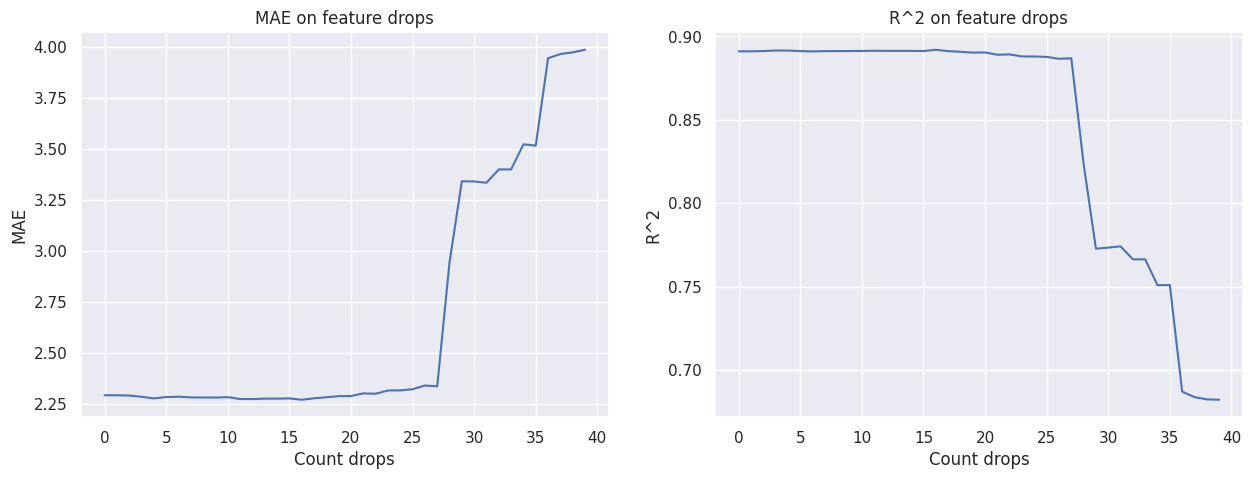

In [38]:
mae_history = []
r2_history = []

for i in range(len(sorted_columns)):
    
    drop_cols = sorted_columns[ :i]
    model = LinearRegression()
    model.fit(df_train.drop(columns = drop_cols), target_train)
    y_pred = model.predict(df_test.drop(columns = drop_cols))
    mae_history.append(mean_absolute_error(target_test.values, y_pred))
    r2_history.append(r2(target_test.values, y_pred))
            

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.title('MAE on feature drops')
plt.plot(np.linspace(0, len(sorted_columns) - 1, len(sorted_columns)), mae_history)
plt.xlabel('Count drops')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.title('R^2 on feature drops')
plt.plot(np.linspace(0, len(sorted_columns) - 1, len(sorted_columns)), r2_history);
plt.xlabel('Count drops')
plt.ylabel('R^2');

In [39]:
pd.DataFrame({'MAE' : mae_history, 'R^2' : r2_history}).head(20)

,MAE,R^2
0,2.294389,0.891097
1,2.294372,0.891085
2,2.292938,0.891247
3,2.286977,0.891584
4,2.278825,0.891545
5,2.285657,0.891193
6,2.287256,0.891028
7,2.283867,0.891184
8,2.283540,0.891218
9,2.283016,0.891266


In [40]:
min(mae_history), max(r2_history)

(2.2723456780757783, 0.8920234707717904)

Видим, что если выкинем первые 16 фичей, то качество будет самым лучшим для такого набора признаков!

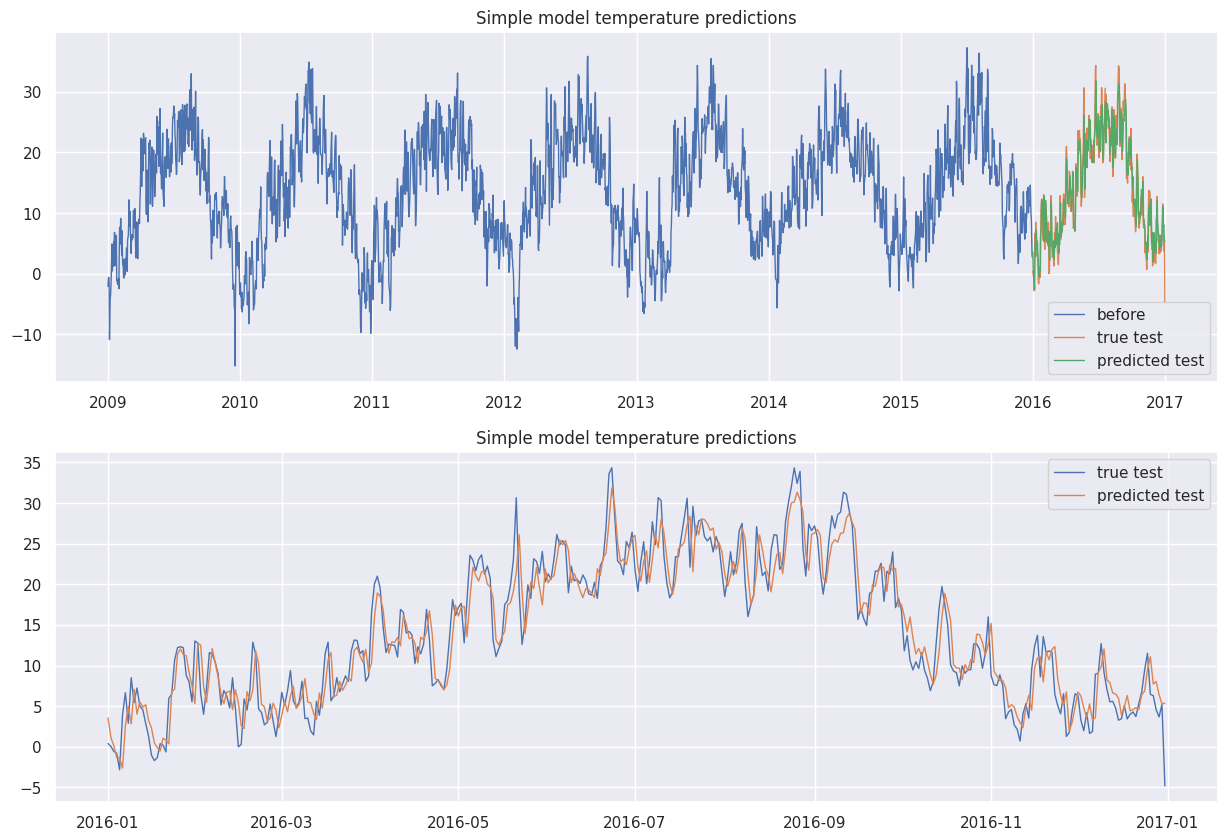

In [41]:
drop_cols = sorted_columns[ :16]
model = LinearRegression()
model.fit(df_train.drop(columns = drop_cols), target_train)
y_pred = model.predict(df_test.drop(columns = drop_cols))

plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.title('Simple model temperature predictions')
plt.plot(df_train.index, target_train, label = 'before', lw = 1)
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

plt.subplot(2, 1, 2)
plt.title('Simple model temperature predictions')
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

In [42]:
add_results_in_comparison_table('linreg drops best', target_test.values, y_pred)

,method,MSE,MAE,MAPE,Median_error,R^2
0,baseline linreg,8.429505,2.294389,187.648533,2.06533,0.891097
1,baseline linreg norm,8.429505,2.294389,187.648533,2.06533,0.891097
2,linreg drops best,8.357781,2.272346,194.572811,1.98851,0.892023


Теперь проведем nested-cross-validation для линейных моделей:

In [115]:
def nested_cross_validation(
    df_train : pd.DataFrame, 
    target_train : str, 
    ts_cv_outer : TimeSeriesSplit, 
    ts_cv_inner : TimeSeriesSplit, 
    algorithms_and_results : pd.DataFrame
    ) -> pd.DataFrame:
    '''
    Description:
        Implementation of nested_cv

    Args:
        df_train (pd.DataFrame): feature matrix
        target_train (str): target columns name
        ts_cv_outer (TimeSeriesSplit): outer cv strategy
        ts_cv_inner (TimeSeriesSplit): inner cv strategy
        algorithms_and_results (pd.DataFrame): matrix of models, grids and pipelines

    Returns:
        Filled algorithms ans results
    '''

    for column in ['scores_cv_inner', 'scores_cv_outer']:
        algorithms_and_results[column] = [[] for _ in range(len(algorithm_names))]

    for outer_train_idx, outer_test_idx in ts_cv_outer.split(df_train, target_train):
        x_train = df_train.iloc[outer_train_idx]
        y_train = target_train.iloc[outer_train_idx]
        x_test = df_train.iloc[outer_test_idx]
        y_test = target_train.iloc[outer_test_idx]

        # The grid search estimators need to be rebuild each outer fold, because the inner loop
        # cross validation can only be defined given the train set from the outer loop.
        grid_search_cv_estimators = {}
        for (name, param_grid, pipeline) in algorithms_and_results[['param_grid', 'pipeline']].itertuples():
            
            # The inner loop for hyperparameter tuning
            grid_search_cv_estimator = GridSearchCV(
                estimator = pipeline,
                param_grid = param_grid,
                scoring = 'r2',
                cv = ts_cv_inner.split(x_train, y_train),
                n_jobs = 4,
                refit = True)
            grid_search_cv_estimator.fit(x_train, y_train)

            outer_score = grid_search_cv_estimator.score(x_test, y_test)
            algorithms_and_results.loc[name, 'scores_cv_inner'].append(round(grid_search_cv_estimator.best_score_, 5))
            algorithms_and_results.loc[name, 'scores_cv_outer'].append(round(outer_score, 5))

    return algorithms_and_results

In [111]:
ts_cv_outer = TimeSeriesSplit(n_splits = 7)
ts_cv_inner = TimeSeriesSplit(n_splits = 3)

In [141]:
%%time
# Initialize models
model_1 = LinearRegression()
model_2 = Lasso()
model_3 = Ridge()

# Initialize pipelines
pipeline_1 = Pipeline([('scaling', StandardScaler()),
                       ('model', model_1)])
pipeline_2 = Pipeline([('scaling', StandardScaler()),
                       ('model', model_2)])
pipeline_3 = Pipeline([('scaling', StandardScaler()),
                       ('model', model_3)])

# Initialize hyperparameter grids
param_grid_1 = {
    'model__fit_intercept': [True, False],
}

param_grid_2 = {
    'model__alpha': [0.5, 0.9, 1, 5],
    'model__fit_intercept': [True, False],
    'model__max_iter': [1000, 2000, 5000],
}

param_grid_3 = {
    'model__alpha': [0.5, 0.9, 1, 5],
    'model__fit_intercept': [True, False],
    'model__max_iter': [1000, 2000, 5000],
}


# Make a DataFrame to save all algorithms and include columns to save the results
algorithms = {
        'param_grid': [param_grid_1, param_grid_2, param_grid_3],                                            
        'pipeline': [pipeline_1, pipeline_2, pipeline_3],
    }

algorithm_names = ['LinReg', 'Lasso', 'Ridge']
algorithms_and_results = pd.DataFrame(algorithms, index = algorithm_names)

algorithms_and_results = nested_cross_validation(
    df_train,
    target_train,
    ts_cv_outer,
    ts_cv_inner,
    algorithms_and_results)

algorithms_and_results

CPU times: user 8.33 s, sys: 9.58 s, total: 17.9 s
Wall time: 11.3 s


,param_grid,pipeline,scores_cv_inner,scores_cv_outer
LinReg,"{'model__fit_intercept': [True, False]}","(StandardScaler(), LinearRegression())","[-25.35172, 0.63033, 0.82966, 0.86141, 0.86128...","[0.87169, 0.87472, 0.83859, 0.89955, 0.8709, 0..."
Lasso,"{'model__alpha': [0.5, 0.9, 1, 5], 'model__fit...","(StandardScaler(), Lasso())","[0.07714, 0.73482, 0.84242, 0.8593, 0.8598, 0....","[0.87539, 0.86522, 0.83746, 0.88771, 0.86051, ..."
Ridge,"{'model__alpha': [0.5, 0.9, 1, 5], 'model__fit...","(StandardScaler(), Ridge())","[-0.05799, 0.73662, 0.84135, 0.86205, 0.86256,...","[0.87732, 0.86835, 0.83719, 0.89677, 0.86758, ..."


In [143]:
for agg_function in [np.mean, np.median, np.std]:
    for column in ['scores_cv_outer', 'scores_cv_inner']:
        aggregation_dict = {column + '_' + agg_function.__name__: lambda df: df[column].map(agg_function)}
        algorithms_and_results = algorithms_and_results.assign(**aggregation_dict)
algorithms_and_results.T

,LinReg,Lasso,Ridge
param_grid,"{'model__fit_intercept': [True, False]}","{'model__alpha': [0.5, 0.9, 1, 5], 'model__fit...","{'model__alpha': [0.5, 0.9, 1, 5], 'model__fit..."
pipeline,"(StandardScaler(), LinearRegression())","(StandardScaler(), Lasso())","(StandardScaler(), Ridge())"
scores_cv_inner,"[-25.35172, 0.63033, 0.82966, 0.86141, 0.86128...","[0.07714, 0.73482, 0.84242, 0.8593, 0.8598, 0....","[-0.05799, 0.73662, 0.84135, 0.86205, 0.86256,..."
scores_cv_outer,"[0.87169, 0.87472, 0.83859, 0.89955, 0.8709, 0...","[0.87539, 0.86522, 0.83746, 0.88771, 0.86051, ...","[0.87732, 0.86835, 0.83719, 0.89677, 0.86758, ..."
scores_cv_outer_mean,0.863251,0.853863,0.860984
scores_cv_inner_mean,-2.919077,0.728604,0.71119
scores_cv_outer_median,0.8709,0.86051,0.86758
scores_cv_inner_median,0.86128,0.8593,0.86205
scores_cv_outer_std,0.024828,0.029339,0.025034
scores_cv_inner_std,9.158432,0.269396,0.316989


In [144]:
best_algorithm_name = algorithms_and_results['scores_cv_outer_mean'].idxmax()
best_pipeline = algorithms_and_results.loc[best_algorithm_name, 'pipeline']
best_param_grid = algorithms_and_results.loc[best_algorithm_name, 'param_grid']
print(f'Choose best estimator: {best_algorithm_name}')

Choose best estimator: LinReg


Попробуем выжать $R^2$ больше 0.9 из линейной регрессии:

In [43]:
drop_cols

['rho (g/m**3)_wmin',
 'wd (deg)_wmedian',
 'wd (deg)_wmin',
 'wd (deg)_wmean',
 'wd (deg)',
 'rho (g/m**3)_wmedian',
 'rho (g/m**3)_wmax',
 'VPmax (mbar)_wmedian',
 'rho (g/m**3)_wmean',
 'wd (deg)_wmax',
 'rho (g/m**3)',
 'VPdef (mbar)_wmax',
 'T (degC)_wmedian',
 'H2OC (mmol/mol)_wmedian',
 'VPdef (mbar)_wmedian',
 'VPdef (mbar)_wmin']

In [53]:
df_train_1 = df_train.drop(columns = drop_cols)
df_test_1 = df_test.drop(columns = drop_cols)

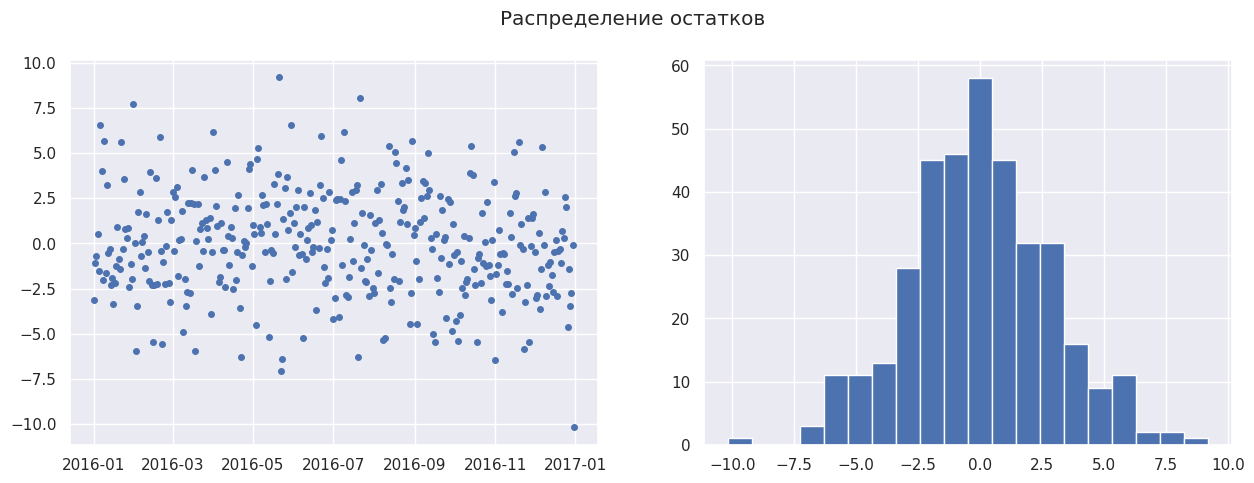

In [70]:
model = LinearRegression()
model.fit(df_train_1, target_train)
y_pred = model.predict(df_test_1)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(target_test - y_pred, 'o', markersize = 4);
plt.subplot(1, 2, 2)
plt.hist(target_test - y_pred, bins = 20)
plt.suptitle('Распределение остатков')
plt.show();

Просто остатки выглядят нормально. Посмотрим на стьюдентизированные остатки:

In [72]:
def get_studentized_residuals(X, y_true, y_pred):
    H = X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)
    rss = ((y_true - y_pred)**2).sum()
    std = rss / (X.shape[0] - X.shape[1] - 1)
    e = (y_true - y_pred) / np.sqrt(std) / np.sqrt(1 - np.diag(H))
    return e

In [90]:
student_residuals = get_studentized_residuals(df_test_1.to_numpy(), target_test['Target'].to_numpy().squeeze(), y_pred.squeeze())

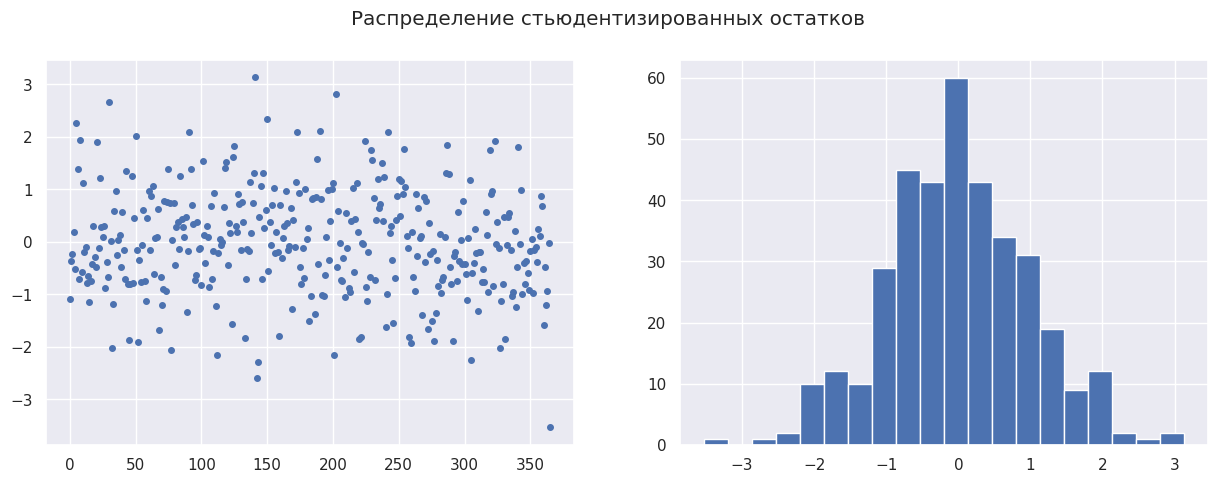

In [91]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(student_residuals, 'o', markersize = 4);
plt.subplot(1, 2, 2)
plt.hist(student_residuals, bins = 20)
plt.suptitle('Распределение стьюдентизированных остатков')
plt.show();

In [92]:
import scipy.stats as sps
sps.normaltest(student_residuals)

NormaltestResult(statistic=1.3312574667919048, pvalue=0.5139502883914331)

Не отвергаем гипотезу о нормальности остатков!

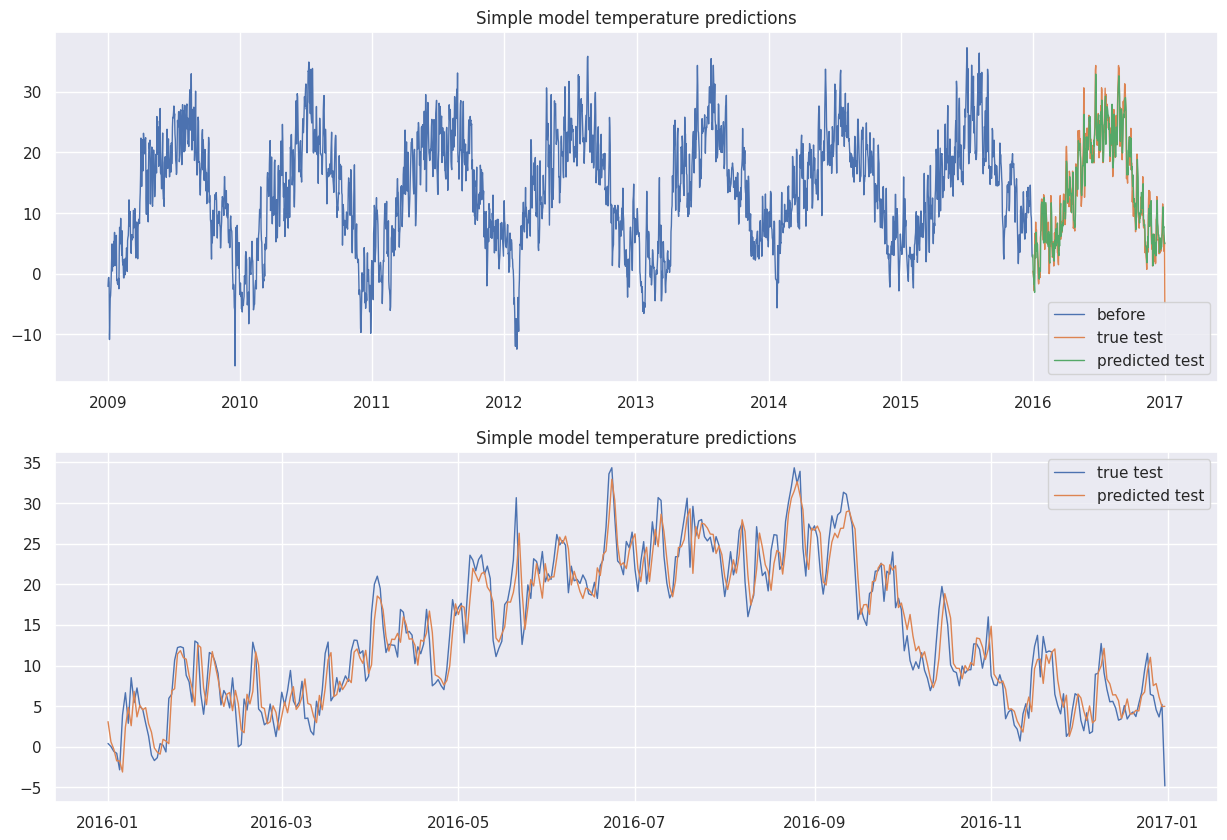

In [152]:
model = LinearRegression()
model.fit(df_train_1, target_train)
y_fit = model.predict(df_train_1)
y_pred = model.predict(df_test_1)

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train_1)
X_test = scaler.transform(df_test_1)

model_res = SVR(epsilon=0.9)
model_res.fit(X_train, target_train - y_fit)
y_pred += model_res.predict(X_test).reshape(-1, 1)

plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.title('Simple model temperature predictions')
plt.plot(df_train.index, target_train, label = 'before', lw = 1)
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

plt.subplot(2, 1, 2)
plt.title('Simple model temperature predictions')
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

In [155]:
add_results_in_comparison_table('linreg+SVR on resids', target_test.values, y_pred)

,method,MSE,MAE,MAPE,Median_error,R^2
0,baseline linreg,8.429505,2.294389,187.648533,2.065330,0.891097
1,baseline linreg norm,8.429505,2.294389,187.648533,2.065330,0.891097
2,linreg drops best,8.357781,2.272346,194.572811,1.988510,0.892023
3,linreg+SVR on resids,8.204562,2.235569,182.394209,1.905087,0.894003


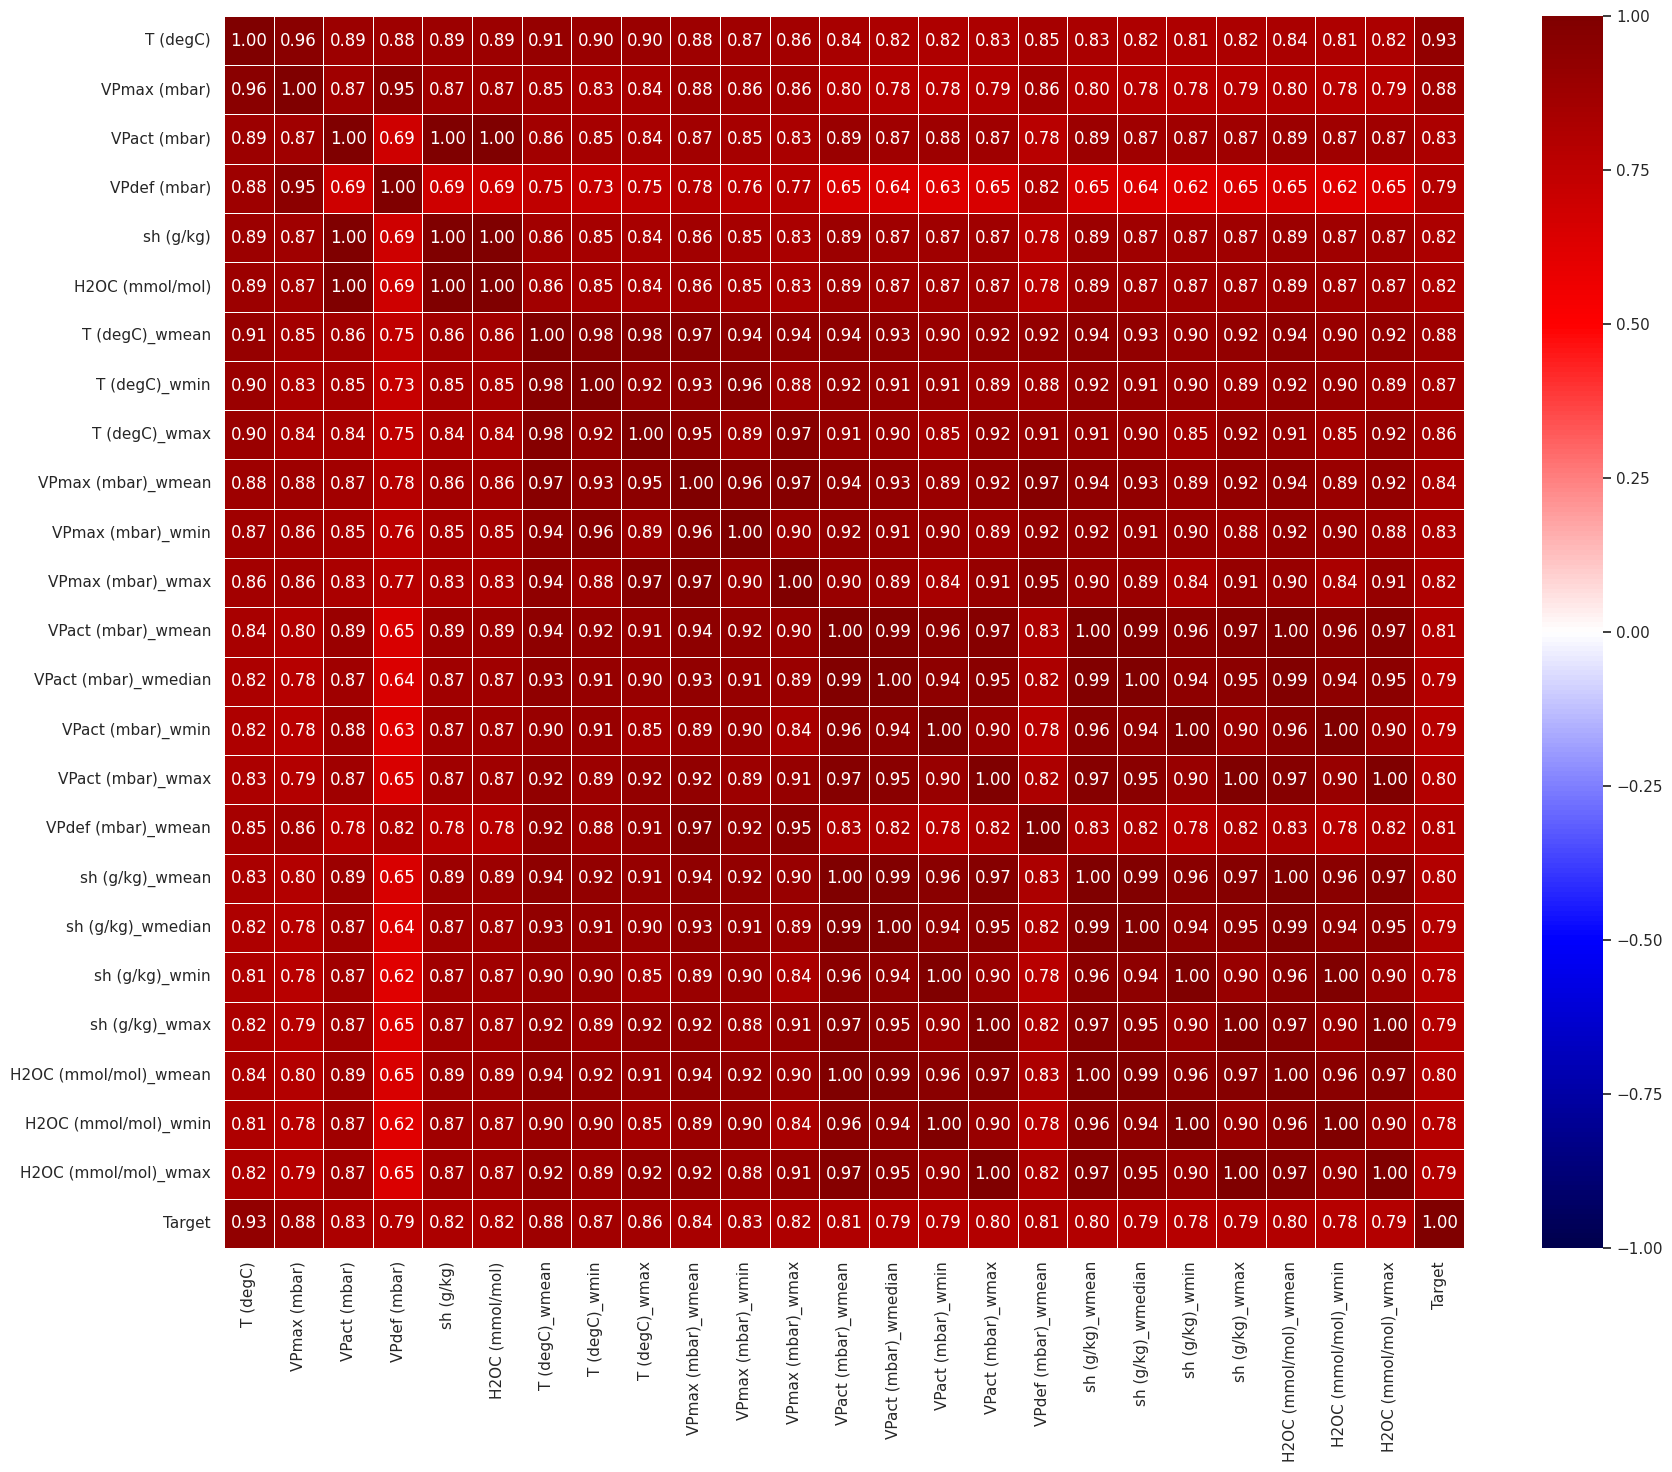

In [150]:
def high_correlated_cols(dataframe, plot = False, corr_th = 0.9):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k = 1).astype(np.bool_))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] >= corr_th)]

    if plot:
        sns.set(rc = {'figure.figsize': (20, 16)})
        sns.heatmap(corr, linewidth = 0.5, cmap = "seismic", vmin = -1, vmax = 1, fmt = '.2f', annot = True)
        plt.show(block=True)
        return drop_list
        
drop_list = high_correlated_cols(pd.concat([df_train_1, target_train], axis = 1), plot = True)

In [220]:
drop_corr_1 = ['sh (g/kg)', 'H2OC (mmol/mol)', 'sh (g/kg)_wmean', 'H2OC (mmol/mol)_wmean', 'sh (g/kg)_wmedian', 'sh (g/kg)_wmin', 'sh (g/kg)_wmax']

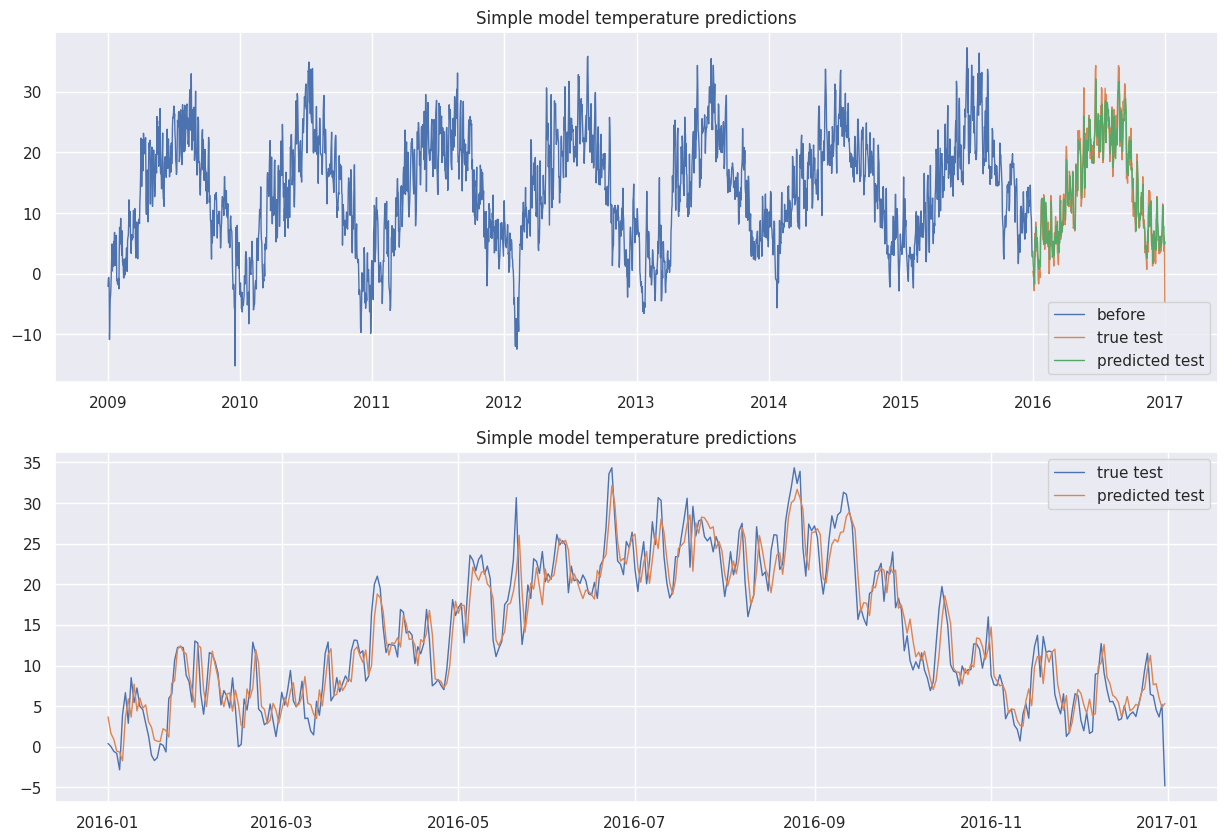

In [218]:
model = LinearRegression()
model.fit(df_train_1, target_train)
y_fit = model.predict(df_train_1)
y_pred = model.predict(df_test_1)

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train_1)
X_test = scaler.transform(df_test_1)

X_train_boxcox = np.array([
    sps.boxcox((X_train - X_train.min(axis = 0) + 0.001)[:, i])[0] for i in range(X_train.shape[1])
]).T
X_test_boxcox = np.array([
    sps.boxcox((X_test - X_test.min(axis = 0) + 0.001)[:, i])[0] for i in range(X_test.shape[1])
]).T

model_res = SVR(
    C = 0.5,
    epsilon = 1.2
)
model_res.fit(X_train_boxcox, target_train - y_fit)
y_pred += model_res.predict(X_test_boxcox).reshape(-1, 1)

plt.figure(figsize = (15, 10))

plt.subplot(2, 1, 1)
plt.title('Simple model temperature predictions')
plt.plot(df_train.index, target_train, label = 'before', lw = 1)
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

plt.subplot(2, 1, 2)
plt.title('Simple model temperature predictions')
plt.plot(df_test.index, target_test, label = 'true test', lw = 1)
plt.plot(df_test.index, y_pred, label = 'predicted test', lw = 1)
plt.legend();

In [219]:
add_results_in_comparison_table('linreg+SVR on resids + boxcox', target_test.values, y_pred)

,method,MSE,MAE,MAPE,Median_error,R^2
0,baseline linreg,8.429505,2.294389,187.648533,2.065330,0.891097
1,baseline linreg norm,8.429505,2.294389,187.648533,2.065330,0.891097
2,linreg drops best,8.357781,2.272346,194.572811,1.988510,0.892023
3,linreg+SVR on resids,8.204562,2.235569,182.394209,1.905087,0.894003
4,linreg+SVR on resids + boxcox,8.185592,2.240340,194.535154,1.980269,0.894248


Видим, что преобразование Бокса-Кокса помогло немного улучшить $R^2$ и $MSE$, но другие метрики немного ухудшились!